In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# Append the parent directory to sys.path
sys.path.append(parent_dir)

# Verify that the parent directory was added
print(sys.path[-1])

/home/yuki/quant_project/EURUSD-LSTM-prediction


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_processing import *
import matplotlib.pyplot as plt
import seaborn

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_tech = pd.read_csv("../Data/EURUSD_OHLC.csv")
# df_tech["Dates"]=pd.to_datetime(df_tech['Dates'])
# df_tech = df_tech[df_tech["Dates"] > pd.to_datetime("2002-01-01") ] 

df_tech["Last_Return"] =((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_tech["Predict_Return"] = ((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_tech.dropna(inplace=True)
df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return
1,1/3/1980,1.5177,1.5177,1.5177,1.5177,0.001848,-0.003163
2,1/4/1980,1.5129,1.5129,1.5129,1.5129,-0.003163,0.002578
3,1/7/1980,1.5168,1.5168,1.5168,1.5168,0.002578,-0.003956
4,1/8/1980,1.5108,1.5108,1.5108,1.5108,-0.003956,0.003508
5,1/9/1980,1.5161,1.5161,1.5161,1.5161,0.003508,-0.001847
...,...,...,...,...,...,...,...
11456,7/1/2024,1.0714,1.0776,1.0711,1.0740,0.002520,0.000466
11457,7/2/2024,1.0740,1.0747,1.0710,1.0745,0.000466,0.003816
11458,7/3/2024,1.0745,1.0817,1.0736,1.0786,0.003816,0.002411
11459,7/4/2024,1.0786,1.0814,1.0784,1.0812,0.002411,0.002590


In [3]:
import sys
import os
# sys.path.append("./factors")
# import tech_indicators
from factors import tech_indicators

EURUSD_close = df_tech['PX_LAST'].to_numpy()
EURUSD_typical = ((df_tech['PX_HIGH']+df_tech['PX_LOW']+df_tech['PX_LAST'])/3).to_numpy()

tech_dict =( {"SMA":[[10]],"EMA":[[50]],"RSI":[[10],[50],[100]],"MACD":[[26,12],[12,5]],"ROC":[[2]],"Bollinger_Bands_lower":[[20],[50]],
             "Bollinger_Bands_upper":[[20],[50]],
              "CCI":[[20],[100]]} )

for key,value in tech_dict.items():
    
    for value in value:
        df_column_name = key
        for para in value:
            df_column_name += ("_"+str(para))
        
        if key[:3] == "CCI":
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_typical,getattr(tech_indicators,key),*value)
            
        else:
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_close,getattr(tech_indicators,key),*value)
        
df_tech.dropna(inplace=True,ignore_index=True)


df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return,SMA_10,EMA_50,RSI_10,...,RSI_100,MACD_26_12,MACD_12_5,ROC_2,Bollinger_Bands_lower_20,Bollinger_Bands_lower_50,Bollinger_Bands_upper_20,Bollinger_Bands_upper_50,CCI_20,CCI_100
0,5/27/1980,1.4725,1.4725,1.4725,1.4725,0.008354,-0.003328,1.45190,1.429335,68.750000,...,51.536492,0.009267,0.007195,0.008354,1.431259,1.340592,1.464671,1.485016,284.727864,34.043608
1,5/28/1980,1.4676,1.4676,1.4676,1.4676,-0.003328,-0.000886,1.45396,1.429185,66.304348,...,51.528245,0.011650,0.007560,-0.003328,1.430308,1.339875,1.467772,1.487073,183.562457,27.108459
2,5/29/1980,1.4663,1.4663,1.4663,1.4663,-0.000886,-0.001159,1.45564,1.426798,73.564882,...,52.064292,0.012238,0.007066,-0.000886,1.430049,1.339321,1.470171,1.489403,142.398522,26.016046
3,5/30/1980,1.4646,1.4646,1.4646,1.4646,-0.001159,-0.001024,1.45715,1.428254,74.718275,...,52.419483,0.009106,0.006509,-0.001159,1.430514,1.339691,1.471906,1.491877,109.547574,24.332424
4,6/2/1980,1.4631,1.4631,1.4631,1.4631,-0.001024,0.000410,1.45876,1.429972,77.293462,...,52.796671,0.007851,0.006710,-0.001024,1.431261,1.340232,1.473169,1.494128,86.049131,22.846588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11356,7/1/2024,1.0714,1.0776,1.0711,1.0740,0.002520,0.000466,1.07164,1.075917,44.444444,...,48.069053,-0.004790,0.000357,0.002520,1.063244,1.064481,1.087676,1.090923,-19.522490,-50.802253
11357,7/2/2024,1.0740,1.0747,1.0710,1.0745,0.000466,0.003816,1.07169,1.075834,44.683136,...,47.821473,-0.003744,-0.000060,0.000466,1.063988,1.064715,1.085592,1.090865,-24.582414,-59.189742
11358,7/3/2024,1.0745,1.0817,1.0736,1.0786,0.003816,0.002411,1.07211,1.076362,54.307116,...,47.744819,-0.002127,0.001312,0.003816,1.064911,1.065083,1.083839,1.090845,64.363332,-13.873299
11359,7/4/2024,1.0786,1.0814,1.0784,1.0812,0.002411,0.002590,1.07321,1.076051,48.441926,...,48.144759,-0.001708,0.002347,0.002411,1.066536,1.065295,1.081434,1.090961,135.292417,9.837970


In [5]:
split_point = int(df_tech.shape[0]*0.9)
df_train = df_tech.iloc[:split_point,:]
df_test = df_tech.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

threshold = threshold_search(y_train,1e-6)

print(threshold)



0.002152


In [6]:
y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

In [7]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':2,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.5}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cuda')

net_test.to(device=device,dtype=torch.float64)
loss = nn.CrossEntropyLoss()


def train_epoch(loss_function, optimizer, model, loader,train_data,test_data):
  loss_train = 0
  loss_test = 0
  
  for(i, (x, y)) in enumerate(loader):
    # Clear the gradients
    optimizer.zero_grad()
    
    x=x.to(device=device)
    y=y.to(device=device)
    # Run a forward pass
    outputs = model.forward(x)
    # Compute the batch loss
    loss = loss_function(outputs,y)
    # Calculate the gradients
    loss.backward()
    # Update the parameteres
    optimizer.step()

    
  with torch.no_grad():
    train_outputs = model.forward(train_data[:][0].to(device=device))
    train_loss = loss_function(train_outputs,train_data[:][1].to(device=device))
    loss_train = train_loss.detach().cpu()
    print(f"train loss is {train_loss}")
    
    test_outputs = model.forward(test_data[:][0].to(device=device))
    test_loss = loss_function(test_outputs,test_data[:][1].to(device=device))
    loss_test = test_loss.detach().cpu()
    print(f"test loss is {test_loss}")
        
  return [loss_train, loss_test]   



def train_model(loss_function, optimizer, model, loader,train_data,test_data,epochs=25):
  loss_ls = []
  
  for i in range(epochs):
    print(f"-----------------------Epoch: {i+1}----------------------------------")

    loss_ls.append(train_epoch(loss_function, optimizer, model, loader,train_data,test_data))
    
  return loss_ls

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [8]:
optim_Adam = torch.optim.Adam(net_test.parameters(),lr = 0.0001)
epochs = 100
loss_ls = train_model(loss_function=loss,optimizer=optim_Adam,model=net_test,loader=train_loader,train_data=train_set,
                      test_data=test_set,epochs=epochs)

-----------------------Epoch: 1----------------------------------
train loss is 1.161029415406189
test loss is 1.1645593284273406
-----------------------Epoch: 2----------------------------------
train loss is 1.1364958315051115
test loss is 1.13104578849915
-----------------------Epoch: 3----------------------------------
train loss is 1.1263745873212136
test loss is 1.125792539056912
-----------------------Epoch: 4----------------------------------
train loss is 1.1185164980730233
test loss is 1.12240383556516
-----------------------Epoch: 5----------------------------------
train loss is 1.1126235377421092
test loss is 1.1094039214910252
-----------------------Epoch: 6----------------------------------
train loss is 1.1091455585060983
test loss is 1.1106396843277047
-----------------------Epoch: 7----------------------------------
train loss is 1.1051782337089044
test loss is 1.1087899748105645
-----------------------Epoch: 8----------------------------------
train loss is 1.1012883

In [11]:
loss_array = np.array(loss_ls).reshape((2,epochs))

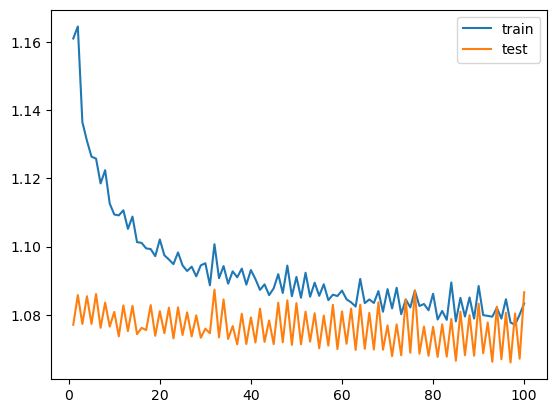

In [12]:
plt.plot(range(1,len(loss_array[0])+1),loss_array[0],label = "train")
plt.plot(range(1,len(loss_array[1])+1),loss_array[1],label= "test")
plt.legend()
plt.show()

In [13]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))
net_test.eval()

predict_probability = torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0]

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]

accuracy_score(real_results,predict_results)

0.4068100358422939

In [16]:
act_predict_bool = (predict_results != 1) & (predict_probability > 0.4)

act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]

accuracy_score(act_predict_results,act_real_results)

0.48936170212765956

In [17]:
act_predict_results.shape

torch.Size([47])

In [18]:
saved_path = "../trained_model/Tec_LSTM.pth"

torch.save(net_test.state_dict(),saved_path )